# Analysis of Winter data 2016

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
from pandas.tseries import offsets
import os
from datetime import date
import holidays

%matplotlib inline  

blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]

uk_hol= holidays.UK() #load UK holiday

import sys


#http://www2.warwick.ac.uk/services/centraltimetabling/help/academicweeks/?acYear=201516

In [2]:
import os
print(os.getcwd())
computer_path= ""
for x in os.getcwd().split("\\"):
    print(x)
    computer_path=computer_path+x+"\\"
    if x == "OneDrive - Cardiff University":
        break    
print(computer_path)


C:\Users\sceac10\OneDrive - Cardiff University\05 - Python\02 - Warwick
C:
Users
sceac10
OneDrive - Cardiff University
C:\Users\sceac10\OneDrive - Cardiff University\


In [3]:
sys.path.append(computer_path + "\\05 - Python\\01 - Packages")
import Classes.regression as regression
# path = r'/Users/macintosh/Documents/OneDrive - Cardiff University/04 - Projects/02 - Warwick/04 - Data/'
path=computer_path+"/04 - Projects/02 - Warwick/04 - Data/"
files = ["ScarmanHouse_ElecEnergykWh.csv", "ScarmanHouse_HeatEnergykWh.csv", "ScarmanHouse_HeatFlowm3.csv"]
drivers = "Coventry OAT 2016 - origin.xls"
saving_path = computer_path+ '04 - Projects/02 - Warwick/01 - Analyses/'

## Cleaning and preparing dataset

In [4]:
def cleanAndPrepare(data, meterName):
    data["Date"]=data["Date"] + " " +data["StartTime"]
    data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y %H:%M")
    data.set_index("Date", drop=True, inplace=True)
    data.drop(["Meter", "Name", "SerialNumber", "Register", "StartTime", "Duration", "TotalValue", "Unit"], axis=1, inplace=True)
    data.columns = [meterName]

In [5]:
frames = []

for filename in files:
    data = pd.read_csv(path+filename)
    meterName = filename.split(".csv")[0]
    cleanAndPrepare(data, meterName)
    print(filename + " has " + '{:d}'.format(data[meterName].isnull().sum()) + " missing data")
    frames.append(data)
    
result = pd.concat(frames,axis=1)
result.set_index(pd.date_range(start=result.index[0], end=result.index[-1], freq='30T' ), inplace=True)
result.head()

ScarmanHouse_ElecEnergykWh.csv has 0 missing data
ScarmanHouse_HeatEnergykWh.csv has 0 missing data
ScarmanHouse_HeatFlowm3.csv has 0 missing data


,ScarmanHouse_ElecEnergykWh,ScarmanHouse_HeatEnergykWh,ScarmanHouse_HeatFlowm3
2016-01-01 00:00:00,26.0,0.1,3.3
2016-01-01 00:30:00,27.0,0.2,3.2
2016-01-01 01:00:00,29.0,0.1,3.3
2016-01-01 01:30:00,29.0,0.1,3.2
2016-01-01 02:00:00,29.0,0.2,3.3


## Add temperature data to the dataset

In [6]:
temperature = pd.read_excel(path+drivers)
temperature.head()
temperature.fillna(method="ffill", inplace=True) #Fill gaps in data with previous

temperature[temperature.columns[0]] = pd.to_datetime(temperature[temperature.columns[0]], format="%Y-%m-%d %H:%M:%S")
temperature.head()
temperature.set_index(temperature.columns[0], drop=True, inplace=True)

temperature = temperature.resample('30T').mean()
temperature = temperature.interpolate('time')
temperature.fillna(method="ffill", inplace=True)
result = result.join(temperature)

## Verifiy integrity of the dataset

In [7]:
numberOfValues = 365*48
if not result.index.year[0]%4:
    numberOfValues = 366*48
print("dataset is " + '{0:.2f}%'.format(result.shape[0]/numberOfValues*100) + " complete")

dataset is 100.00% complete


In [8]:
result.columns = ["Electricity", "Heat", "HeatFlow", "Temperature"]
result.head()

,Electricity,Heat,HeatFlow,Temperature
2016-01-01 00:00:00,26.0,0.1,3.3,2.7300
2016-01-01 00:30:00,27.0,0.2,3.2,2.6400
2016-01-01 01:00:00,29.0,0.1,3.3,2.5500
2016-01-01 01:30:00,29.0,0.1,3.2,1.5425
2016-01-01 02:00:00,29.0,0.2,3.3,0.5350


In [9]:
result["Hour"] = result.index.hour
result["DayOfWeek_name"]= [calendar.day_name[x] for x in result.index.dayofweek]
result["DayOfWeek"]= result.index.dayofweek
result["Month"] = result.index.month
result["Weekday"] = [1 if x<5 else 0 for x in result.index.dayofweek]
result["HH"] = [x%48 for x in range(0, result.shape[0], 1) ]
result["Holiday"]= [1 if x.date() in uk_hol else 0 for x in result.index]
result["Date"] = result.index.date
result["Week"] = result.index.week

def get_season(row):
    if row['Month'] >= 3 and row['Month'] <= 5:
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 8:
        return 'Summer'
    elif row['Month'] >= 9 and row['Month'] <= 11:
        return 'Autumn'
    else:
        return 'Winter'

season_dict = {"Winter":1, "Spring":2, "Summer":3, "Autumn":4}
inv_season_dict = {v: k for k, v in season_dict.items()}
result['Season'] = result.apply(get_season, axis=1)
result['Season num'] = result['Season']
result.replace({"Season num":season_dict}, inplace=True)
result.head()

,Electricity,Heat,HeatFlow,Temperature,Hour,DayOfWeek_name,DayOfWeek,Month,Weekday,HH,Holiday,Date,Week,Season,Season num
2016-01-01 00:00:00,26.0,0.1,3.3,2.7300,0,Friday,4,1,1,0,1,2016-01-01,53,Winter,1
2016-01-01 00:30:00,27.0,0.2,3.2,2.6400,0,Friday,4,1,1,1,1,2016-01-01,53,Winter,1
2016-01-01 01:00:00,29.0,0.1,3.3,2.5500,1,Friday,4,1,1,2,1,2016-01-01,53,Winter,1
2016-01-01 01:30:00,29.0,0.1,3.2,1.5425,1,Friday,4,1,1,3,1,2016-01-01,53,Winter,1
2016-01-01 02:00:00,29.0,0.2,3.3,0.5350,2,Friday,4,1,1,4,1,2016-01-01,53,Winter,1


## Overview of the data at half-hourly resolution

Using half-hourly resolution, there are issues around the continuity of the data as well as the possible time delay of the system reaction. For instance, the heatflow may not be at the expected temperature at every given time.

It is still possible to predict linear relation between heat, heat flow and temperature but it will become clearer at daily resolution.

C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


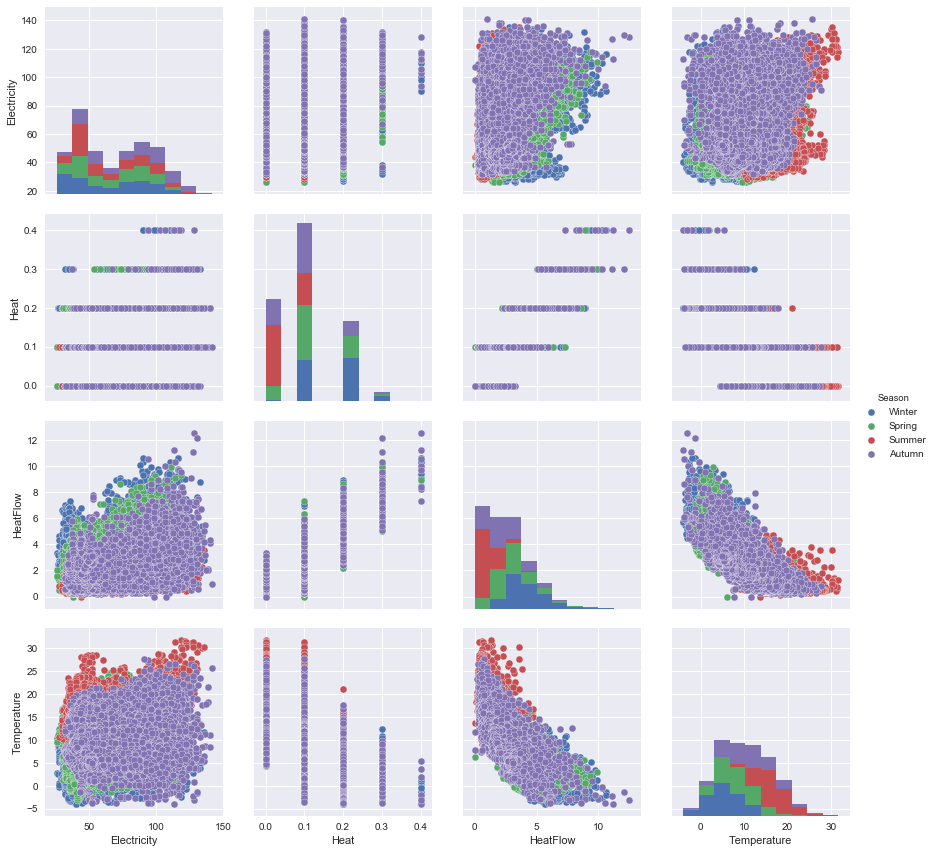

In [10]:
sns.pairplot(result[["Electricity", "Heat", "HeatFlow", "Temperature", "Season"]], hue="Season", size=3)
plt.savefig(saving_path+"half-hourly.png")

## Overview of the data at daily resolution

In [11]:
daily_data = result.resample("d").agg({"Heat": np.sum,"Electricity": np.sum,"HeatFlow": np.sum, "Temperature":np.mean, "Season num":np.mean})

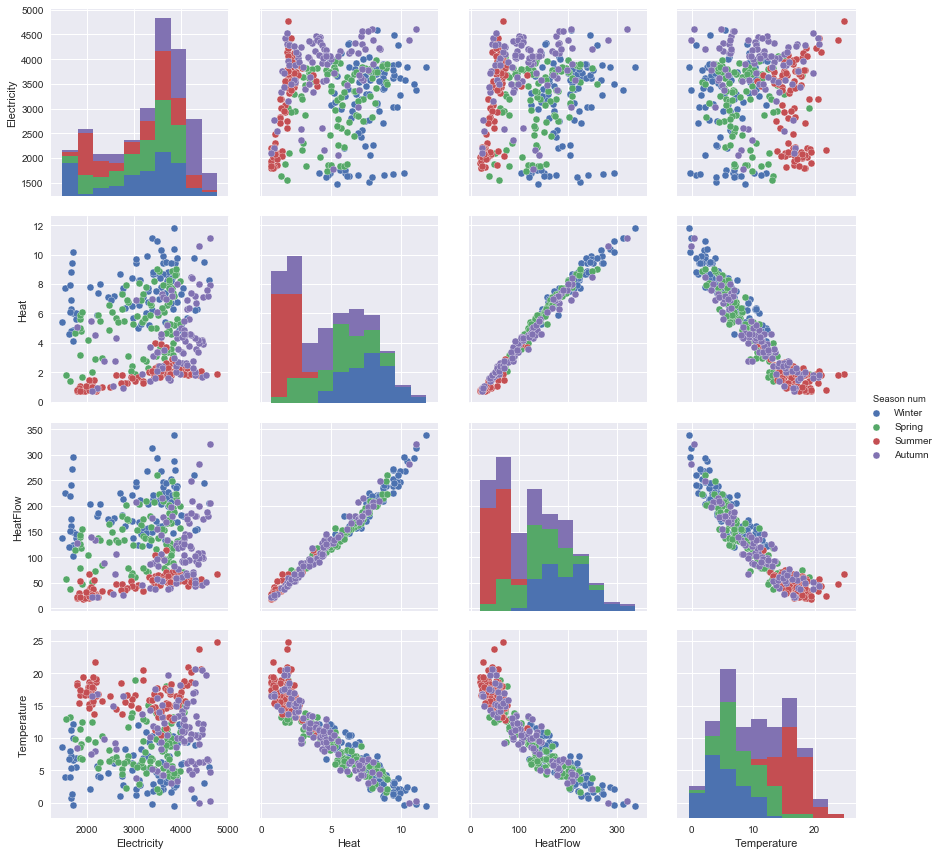

In [12]:
result.fillna(-1, inplace=True)
daily_data.replace({"Season num":inv_season_dict}, inplace=True)
sns.pairplot(daily_data[["Electricity", "Heat", "HeatFlow", "Temperature", "Season num"]], hue="Season num", size=3)
plt.savefig(saving_path+"daily.png")

The main points are: 
-low heat demand during summer time, 
-higher electricity demand in autumn,
-linear regression between heat and heat flow
-linear regression between heat/heat flow and temperature until change point is reached (~15C)
-low heat network utilisation during summer time


# Electricity

## Annual consumption

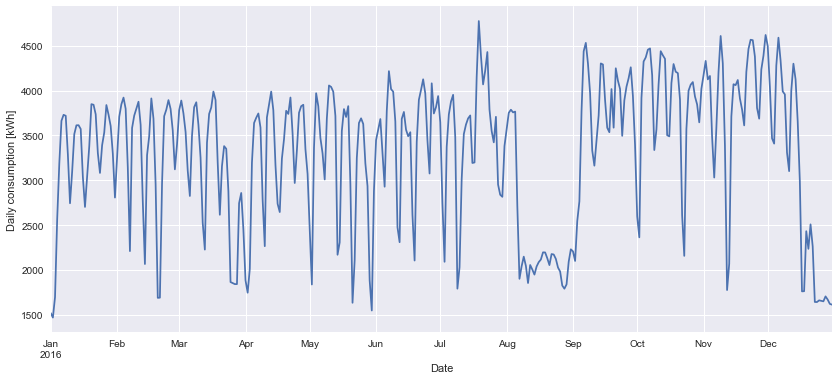

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))
result["Electricity"].resample('d').sum().plot(ax=fig.gca())
ax.set_xlabel("Date")
ax.set_ylabel("Daily consumption [kWh]")
plt.savefig(saving_path+"annual_elec.png")

## HH consumption for the average week by season 

Based on the graph below, we could split our analysis in two: the first cluster would be the Autumn data and the 

In [14]:
averageWeekbyHH = result.groupby(["DayOfWeek_name", "HH", "Season"]).mean().reset_index()
averageWeekbyHH["index"]= averageWeekbyHH["DayOfWeek"] + averageWeekbyHH["HH"]/100#averageWeekbyHH["DayOfWeek"].map(str) + " " + averageWeekbyHH["HH"].map(str)
averageWeekbyHH.set_index(["index", "Season"], inplace=True)
averageWeekbyHH.sort_values(["DayOfWeek", "HH"], inplace=True)
df = averageWeekbyHH.unstack("Season")
df.set_index(df["DayOfWeek_name", "Autumn"], inplace=True)
df.head()

DayOfWeek_name                             HH         \
Season                           Autumn  Spring  Summer  Winter Autumn Spring   
(DayOfWeek_name, Autumn)                                                        
Monday                           Monday  Monday  Monday  Monday      0      0   
Monday                           Monday  Monday  Monday  Monday      1      1   
Monday                           Monday  Monday  Monday  Monday      2      2   
Monday                           Monday  Monday  Monday  Monday      3      3   
Monday                           Monday  Monday  Monday  Monday      4      4   

                                       Electricity             ...    \
Season                   Summer Winter      Autumn     Spring  ...     
(DayOfWeek_name, Autumn)                                       ...     
Monday                        0      0   44.153846  38.692308  ...     
Monday                        1      1   43.230769  37.846154  ...     
Monday                        2      2   42.000000  37.461538  ...     
Monday                        3      3   41.307692  37.153846  ...     
Monday                        4      4   40.692308  38.000000  ...     

                           Holiday             Week                       \
Season                      Summer    Winter Autumn Spring Summer Winter   
(DayOfWeek_name, Autumn)                                                   
Monday                    0.153846  0.153846   42.0   16.0   29.0   19.0   
Monday                    0.153846  0.153846   42.0   16.0   29.0   19.0   
Monday                    0.153846  0.153846   42.0   16.0   29.0   19.0   
Monday                    0.153846  0.153846   42.0   16.0   29.0   19.0   
Monday                    0.153846  0.153846   42.0   16.0   29.0   19.0   

                         Season num                       
Season                       Autumn Spring Summer Winter  
(DayOfWeek_name, Autumn)                                  
Monday                          4.0    2.0    3.0    1.0  
Monday                          4.0    2.0    3.0    1.0  
Monday                          4.0    2.0    3.0    1.0  
Monday                          4.0    2.0    3.0    1.0  
Monday                          4.0    2.0    3.0    1.0  

[5 rows x 52 columns]

In [41]:
daybyHH = result.groupby(["Date", "HH"]).mean()
daybyHH=daybyHH.unstack("HH").reset_index()
daybyHH["Date"]=pd.to_datetime(daybyHH["Date"], format="%Y-%m-%d")
daybyHH.set_index("Date", inplace=True, drop=True)

In [42]:
daybyHH.head()

Electricity                                                        \
HH                  0     1     2     3     4     5     6     7     8     9    
Date                                                                           
2016-01-01        26.0  27.0  29.0  29.0  29.0  29.0  29.0  30.0  28.0  29.0   
2016-01-02        28.0  28.0  28.0  28.0  28.0  29.0  28.0  28.0  27.0  28.0   
2016-01-03        28.0  28.0  28.0  29.0  29.0  28.0  30.0  29.0  28.0  28.0   
2016-01-04        33.0  34.0  34.0  33.0  34.0  32.0  33.0  33.0  32.0  33.0   
2016-01-05        36.0  35.0  36.0  36.0  36.0  34.0  34.0  34.0  35.0  33.0   

           ... Season num                             
HH         ...         38 39 40 41 42 43 44 45 46 47  
Date       ...                                        
2016-01-01 ...          1  1  1  1  1  1  1  1  1  1  
2016-01-02 ...          1  1  1  1  1  1  1  1  1  1  
2016-01-03 ...          1  1  1  1  1  1  1  1  1  1  
2016-01-04 ...          1  1  1  1  1  1  1  1  1  1  
2016-01-05 ...          1  1  1  1  1  1  1  1  1  1  

[5 rows x 528 columns]

In [43]:
from sklearn.cluster import KMeans
from sklearn import metrics

def cluster(values):
    algorithm = "elkan"
    min_silhouette_avg = 0.
    cluster_centers=[]
    cluster_labels=[]
    for n_clusters in range(2, 17, 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, algorithm="elkan", n_init=30).fit(values)
        labels_temp= kmeans.labels_
        silhouette_avg = metrics.silhouette_score(values, labels_temp)
        
        silhouette_samples_values = metrics.silhouette_samples(values, labels_temp)
        calinski_harabaz_score= metrics.calinski_harabaz_score(values, labels_temp)
        nb_values_over = 0
        print("cluster:", n_clusters , "silhouette score:" ,silhouette_avg, "calinski_harabaz:",calinski_harabaz_score )
        if min_silhouette_avg<silhouette_avg:
            min_silhouette_avg=silhouette_avg
            cluster_centers= kmeans.cluster_centers_
            cluster_labels= labels_temp

        nb_values_over = len(silhouette_samples_values[np.where(silhouette_samples_values>silhouette_avg)])
        print("Number of values over average:", nb_values_over, "({:04.1f}%)".format(nb_values_over/len(values)*100)) 
        
    return cluster_centers.shape[0], cluster_centers, cluster_labels

In [44]:
nb_clusters, cluster_centers, cluster_labels = cluster(daybyHH["Electricity"].values)
daybyHH["Labels Kmeans"] = cluster_labels
daybyHH.set_index("Labels Kmeans", append=True, inplace=True)
df_to_plot= daybyHH.reorder_levels(["Labels Kmeans", "Date"], axis=0)
df_to_plot=  df_to_plot["Electricity"].sort_index(axis=0).transpose()

cluster: 2 silhouette score: 0.559149563755 calinski_harabaz: 659.77892872
Number of values over average: 256 (69.9%)
cluster: 3 silhouette score: 0.402555621789 calinski_harabaz: 552.375099617
Number of values over average: 202 (55.2%)
cluster: 4 silhouette score: 0.330600226914 calinski_harabaz: 496.686611447
Number of values over average: 174 (47.5%)
cluster: 5 silhouette score: 0.287549664829 calinski_harabaz: 427.612160092
Number of values over average: 168 (45.9%)
cluster: 6 silhouette score: 0.28388734803 calinski_harabaz: 382.292000036
Number of values over average: 160 (43.7%)
cluster: 7 silhouette score: 0.262844176367 calinski_harabaz: 347.392909108
Number of values over average: 175 (47.8%)
cluster: 8 silhouette score: 0.257936144074 calinski_harabaz: 322.844477553
Number of values over average: 176 (48.1%)
cluster: 9 silhouette score: 0.249643087792 calinski_harabaz: 305.157633763
Number of values over average: 173 (47.3%)
cluster: 10 silhouette score: 0.244777786843 calin

In [38]:
df_to_plot.head()

Labels Kmeans     0                                                        \
index            1     2     3     4     5     6     7     8     9     10   
0              33.5  39.0  37.5  43.5  41.0  40.5  43.5  33.5  40.0  40.5   
1              33.5  36.5  37.0  41.0  38.5  40.0  42.5  33.0  38.5  40.5   
2              33.0  36.0  37.0  39.0  39.5  38.0  44.5  34.0  38.5  38.5   
3              33.0  37.0  37.5  40.0  38.0  39.0  43.5  34.0  37.0  37.5   
4              32.5  35.5  36.5  41.5  38.0  37.0  42.0  34.0  37.0  36.0   

Labels Kmeans  ...                        1                                \
index          ...     48    49    50    12    13    32    33    34    35   
0              ...   52.5  47.5  41.5  38.0  35.0  35.5  39.0  42.5  37.5   
1              ...   52.5  43.0  39.5  37.0  35.0  34.0  40.0  44.5  36.5   
2              ...   51.0  42.0  38.5  36.5  36.0  37.0  38.0  41.5  36.0   
3              ...   49.5  42.0  37.5  38.0  35.5  33.5  38.5  41.5  36.0   
4              ...   49.0  41.0  37.5  36.0  35.0  34.0  36.5  44.0  37.0   

Labels Kmeans        
index            51  
0              36.0  
1              34.5  
2              35.0  
3              34.5  
4              35.0  

[5 rows x 51 columns]

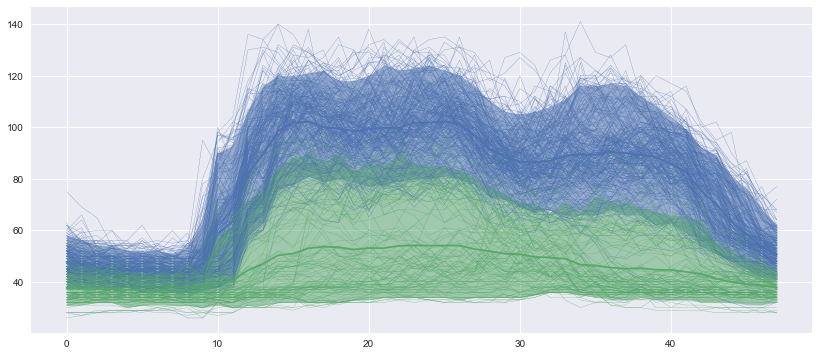

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
color=["blue", "green", "black"]
x=[val for val in df_to_plot.index]
for n_cluster in range(nb_clusters):
    y1= df_to_plot.loc[:, n_cluster].quantile(0.05, axis=1).values
    y2= df_to_plot.loc[:, n_cluster].quantile(0.95, axis=1).values
    ax.fill_between(x, y1, y2, color=sns.color_palette()[n_cluster], alpha=0.5)
    plt.plot(x, cluster_centers[n_cluster], color=sns.color_palette()[n_cluster], alpha=1)
    plt.plot(x, df_to_plot.loc[:, n_cluster], color=sns.color_palette()[n_cluster], alpha=0.8, linewidth=0.3)
    
plt.savefig(saving_path+"cluster_day.png")

In [19]:
weekByHour = result.groupby(["Week", "DayOfWeek", "Hour"]).mean()
weekByHour = weekByHour.unstack("Week")["Electricity"].reset_index()
weekByHour.dropna(how="any", axis=1, inplace=True)
weekByHour.drop(["DayOfWeek", "Hour"],axis=1, inplace=True)

In [20]:
weekByHour=weekByHour.transpose()

In [21]:
nb_clusters, cluster_centers, cluster_labels = cluster(weekByHour.values)
weekByHour["Labels Kmeans"] = cluster_labels
weekByHour.index.name = "index"
weekByHour.set_index("Labels Kmeans", append=True, inplace=True)
df_to_plot= weekByHour.reorder_levels(["Labels Kmeans", "index"], axis=0)
df_to_plot=  df_to_plot.sort_index(axis=0).transpose()

cluster: 2 silhouette score: 0.497140458987 calinski_harabaz: 37.5264012564
Number of values over average: 32 (62.7%)
cluster: 3 silhouette score: 0.287398999894 calinski_harabaz: 33.867329197
Number of values over average: 22 (43.1%)
cluster: 4 silhouette score: 0.296858133126 calinski_harabaz: 33.1582242729
Number of values over average: 28 (54.9%)
cluster: 5 silhouette score: 0.284903051425 calinski_harabaz: 29.0223055336
Number of values over average: 25 (49.0%)
cluster: 6 silhouette score: 0.255981778761 calinski_harabaz: 25.1803888829
Number of values over average: 23 (45.1%)
cluster: 7 silhouette score: 0.272868127199 calinski_harabaz: 23.4441796286
Number of values over average: 26 (51.0%)
cluster: 8 silhouette score: 0.225022842021 calinski_harabaz: 22.0961647273
Number of values over average: 23 (45.1%)
cluster: 9 silhouette score: 0.243471478184 calinski_harabaz: 21.3964447183
Number of values over average: 24 (47.1%)
cluster: 10 silhouette score: 0.210008864693 calinski_har

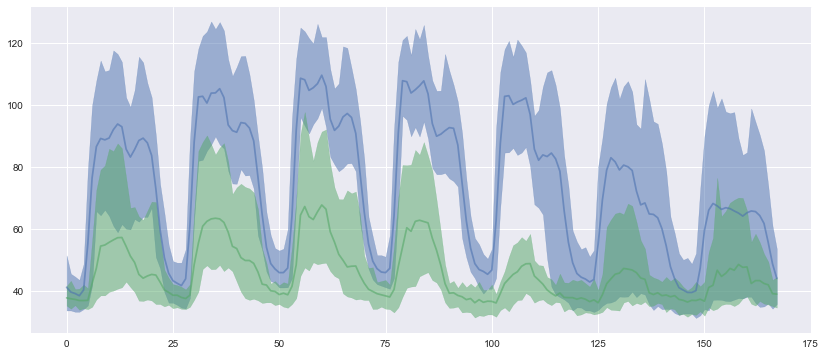

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))
color=["blue", "green", "black"]
x=[val for val in df_to_plot.index]
for n_cluster in range(nb_clusters):
    y1= df_to_plot.loc[:, n_cluster].quantile(0.05, axis=1).values
    y2= df_to_plot.loc[:, n_cluster].quantile(0.95, axis=1).values
    ax.fill_between(x, y1, y2, color=sns.color_palette()[n_cluster], alpha=0.5)
    plt.plot(x, cluster_centers[n_cluster], color=sns.color_palette()[n_cluster], alpha=0.6)

plt.savefig(saving_path+"cluster_week.png")

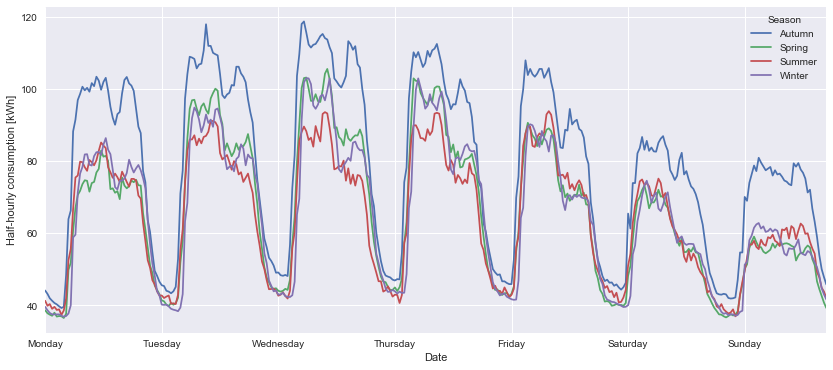

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))
df["Electricity"].plot(ax=fig.gca())
ax.set_xlabel("Date")
ax.set_ylabel("Half-hourly consumption [kWh]")
plt.savefig(saving_path+"average_week_by_HH_electricity.png")

## Average day (weekend and weekday)

The graph below shows the average consumption over a week day and a weekend day. The consumption starts to increase from 5am to reach its peak around 7:30am and 12am. Thereafter it decreases until 3pm plateau until 8pm then decreases again. The pattern reflects a building being used mainly from 7:30am to 8pm. 

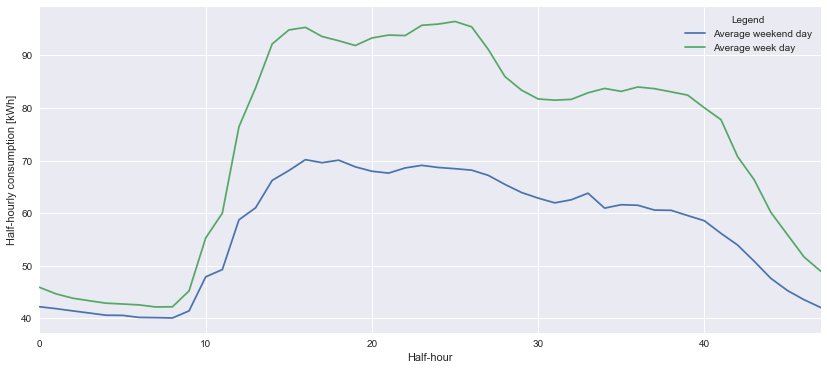

In [24]:
averageDaybyHH = result.groupby(["Weekday", "HH"]).mean()
fig, ax = plt.subplots(figsize=(14, 6))
averageDaybyHH.unstack("Weekday")["Electricity"].plot(ax=fig.gca())
lines, labels = ax.get_legend_handles_labels()
labels = ["Average weekend day", "Average week day"]
ax.legend(lines, labels, title="Legend")
ax.set_xlabel("Half-hour")
ax.set_ylabel("Half-hourly consumption [kWh]")
plt.savefig(saving_path+"average_day_electricity.png")

# Heat and Heat flow

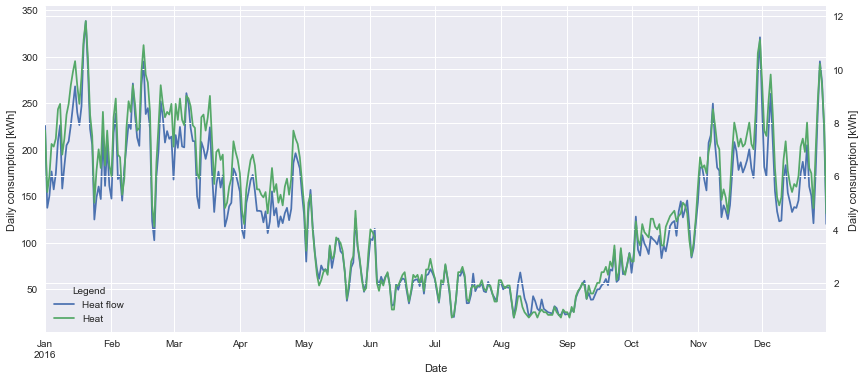

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))
# result["Heat"].resample('d').sum().plot(ax=fig.gca())
result["HeatFlow"].resample('d').sum().plot(ax=ax, label="Heat flow")
ax2 =ax.twinx()
result["Heat"].resample('d').sum().plot(ax=ax2, color=sns.color_palette()[1], label="Heat")
ax.set_xlabel("Date")
ax.set_ylabel("Daily consumption [kWh]")
ax2.set_ylabel("Daily consumption [kWh]")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines= lines+lines2
labels=labels+labels2
ax.legend(lines, labels, title="Legend")
plt.savefig(saving_path+"heat_heat_flow.png")

## As seen in the graph above, the linear relation between Heat and Heat flow can be observed again in the graph below.

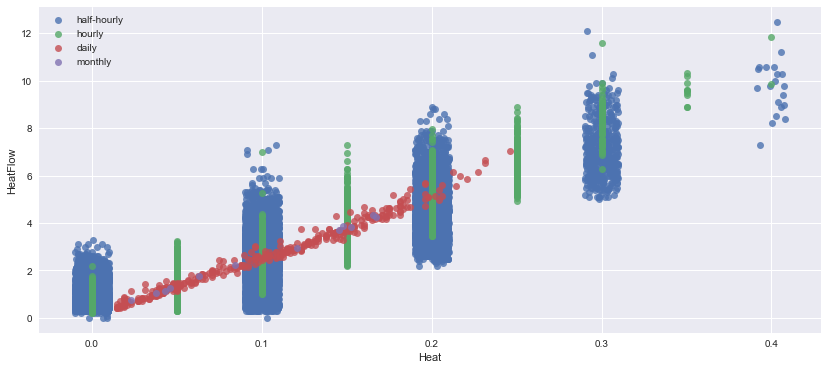

In [26]:
x_data = "Heat"
y_data = "HeatFlow"
fig, ax = plt.subplots(figsize=(14, 6))
sns.regplot(x=x_data, y=y_data, data=result, fit_reg=False, ax=ax, label="half-hourly", x_jitter=0.01)
sns.regplot(x=x_data, y=y_data, data=result.resample("H").mean(), fit_reg=False, ax=ax, label="hourly")
sns.regplot(x=x_data, y=y_data, data=result.resample("d").mean(), fit_reg=False, ax=ax, label="daily")
sns.regplot(x=x_data, y=y_data, data=result.resample("m").mean(), fit_reg=False, ax=ax, label="monthly")
legend = plt.legend()

# Heat

## Relation between Heat and Temperature 

We can observe that the relation between heat and temperature at half hourly resolution is not obvious. Although at daily and monthly resolution, the relation becomes obvious and we can observe a linear relation between the two when temperature is below ~15C and a flat line when above. This difference can be explained by the delay in reaction of the system to the outdoor temperature. 
More details can be found about shift-error and change point model here: http://www.ibpsa.us/sites/default/files/publications/SB10-PPT-IS09C-02-Kissock.pdf

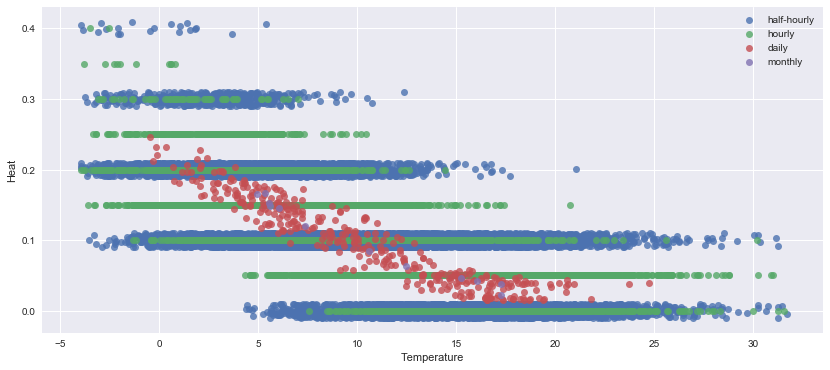

In [27]:
x_data = "Temperature"
y_data = "Heat"
fig, ax = plt.subplots(figsize=(14, 6))
sns.regplot(x=x_data, y=y_data, data=result, fit_reg=False, ax=ax, label="half-hourly", y_jitter=0.01)
sns.regplot(x=x_data, y=y_data, data=result.resample("H").mean(), fit_reg=False, ax=ax, label="hourly")
sns.regplot(x=x_data, y=y_data, data=result.resample("d").mean(), fit_reg=False, ax=ax, label="daily")
sns.regplot(x=x_data, y=y_data, data=result.resample("m").mean(), fit_reg=False, ax=ax, label="monthly")
legend = plt.legend()

plt.savefig(saving_path+"Temperature_heat.png")

Regression
equation: Y= 1.414362-0.549875*X*(T-16.688995 )


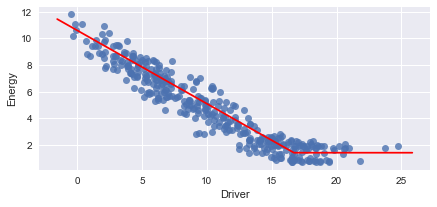

In [28]:
model = regression.Regression()
model._model(daily_data[["Heat", "Temperature"]].copy(), verbose_eval=False)
model._plot()
params= model.param
plt.savefig(saving_path+"change_point_regression.png")

## Using the equation calculated previously, we can estimate the breakdown between space heating consumption and hot water consumption

In [29]:
daily_data["Space heating"]= [params[1]*(temp-params[2]) if temp<params[2] else 0 for temp in daily_data["Temperature"]]
daily_data["Hot water"] = daily_data["Heat"] - daily_data["Space heating"]
daily_data.loc[daily_data["Hot water"]<0, "Hot water"]=0
daily_data.head()

,Heat,Electricity,HeatFlow,Temperature,Season num,Space heating,Hot water
2016-01-01,7.7,1519.0,225.4,3.924167,Winter,7.019064,0.680936
2016-01-02,5.4,1469.0,137.3,8.621354,Winter,4.436197,0.963803
2016-01-03,6.0,1697.0,150.0,6.668958,Winter,5.509771,0.490229
2016-01-04,7.2,2561.0,176.4,6.145417,Winter,5.797654,1.402346
2016-01-05,7.1,3187.0,157.1,6.905208,Winter,5.379863,1.720137


## Breakdown of the heating consumption by end-uses: space heating and hot water (stacked)

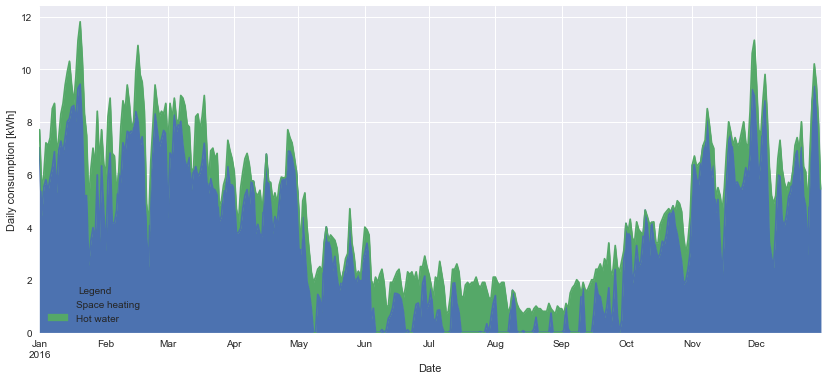

In [30]:
fig, ax = plt.subplots(figsize=(14, 6))
daily_data[["Space heating", "Hot water"]].plot.area(ax=ax, stacked=True)
ax.set_xlabel("Date")
ax.set_ylabel("Daily consumption [kWh]")
ax.legend(title="Legend")

plt.savefig(saving_path+"Heat_breakdown.png")

In [31]:
# sns.palplot(sns.cubehelix_palette(12, light=.7, dark=.2))
palette = sns.cubehelix_palette(12, light=.7, dark=.2)
# palette = palette + (sns.cubehelix_palette(12, light=.7, dark=.2, reverse=True))

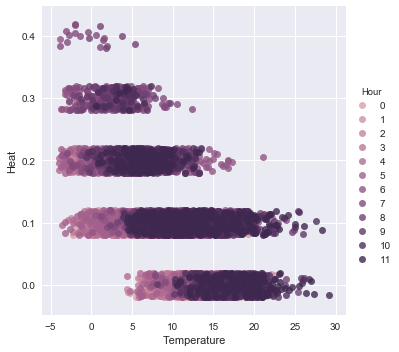

In [32]:
hourly_data = result.resample("H").agg({"Heat": np.sum,"Electricity": np.sum,"HeatFlow": np.sum, "Temperature":np.mean, "Hour":np.mean, "Month":np.mean})

g = sns.lmplot(x="Temperature", y="Heat", hue="Hour", data=result.loc[result["Hour"]<12, :] , fit_reg=False, palette=palette, y_jitter=0.02)
plt.savefig(saving_path+"Heat_temperature_by_HH.png")

In [33]:
hourly_data.head()

,Heat,Electricity,HeatFlow,Temperature,Hour,Month
2016-01-01 00:00:00,0.3,53.0,6.5,2.68500,0,1
2016-01-01 01:00:00,0.2,58.0,6.5,2.04625,1,1
2016-01-01 02:00:00,0.3,58.0,7.1,0.40750,2,1
2016-01-01 03:00:00,0.3,59.0,8.0,0.19325,3,1
2016-01-01 04:00:00,0.3,57.0,8.2,0.46800,4,1


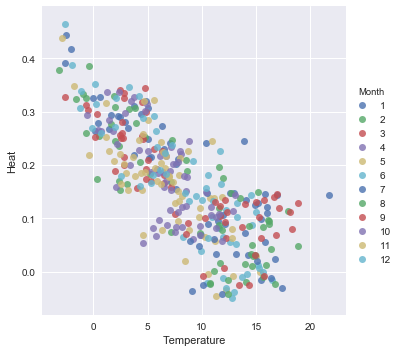

In [34]:
g = sns.lmplot(x="Temperature", y="Heat", hue="Month", data=hourly_data.loc[hourly_data["Hour"]==2, :] , fit_reg=False, palette=sns.color_palette(), y_jitter=0.05)

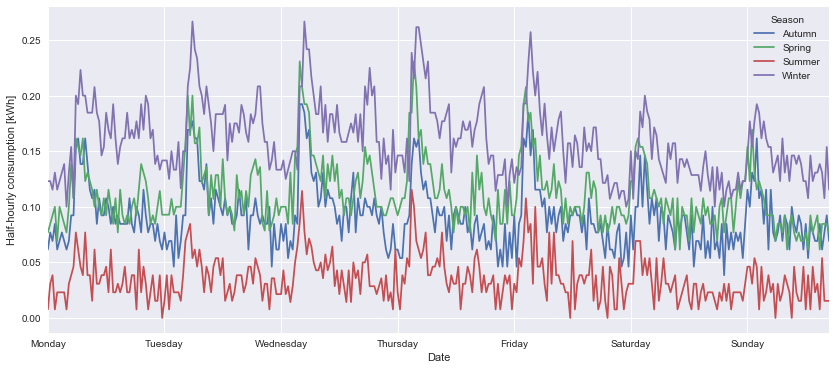

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))
df["Heat"].plot(ax=fig.gca())
ax.set_xlabel("Date")
ax.set_ylabel("Half-hourly consumption [kWh]")
plt.savefig(saving_path+"average_week_by_HH_heat.png")

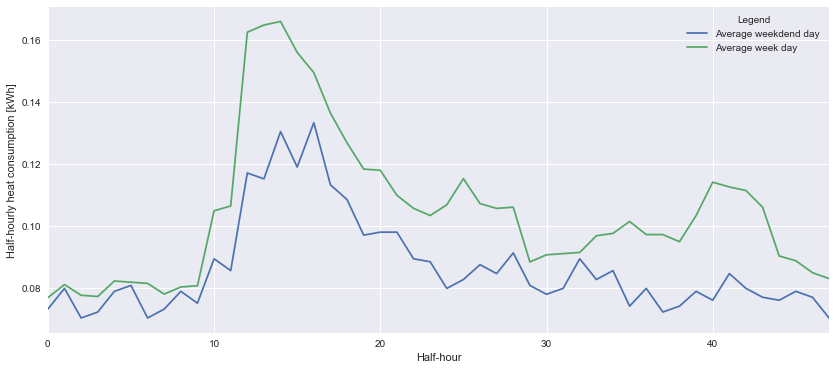

In [36]:
averageDaybyHH = result.groupby(["Weekday", "HH"]).mean()
fig, ax = plt.subplots(figsize=(14, 6))
averageDaybyHH.unstack("Weekday")["Heat"].plot(ax=fig.gca())
lines, labels = ax.get_legend_handles_labels()
labels = ["Average weekdend day", "Average week day"]
ax.legend(lines, labels, title="Legend")
ax.set_xlabel("Half-hour")
ax.set_ylabel("Half-hourly heat consumption [kWh]")
plt.savefig(saving_path+"average_day_heat.png")